# Portfolio Optimization

Install YFinance to fetch real-time stock data

In [1]:
#Install YFinance to fetch real-time stock data
!pip install yfinance

In [2]:
#Import Required Libraries
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

#### Define Tickers and Time Range

In [3]:
#Define the list of Tickers
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [4]:
#Set the end date to today
end_date = datetime.today()

In [5]:
#Set the start date to 5 years ago
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2020-07-29 20:37:59.020988


#### Download Adjusted Close Prices

In [6]:
# Create an empty Dataframe to store the adjusted close prices 
adj_close_df = pd.DataFrame()

In [7]:
# Download the close prices for each other
for ticker in tickers:
    data = yf.download(ticker, start= start_date, end= end_date)
    adj_close_df[ticker] = data['Close']

C:\Users\hp\AppData\Local\Temp\ipykernel_25376\3348814171.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start= start_date, end= end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\hp\AppData\Local\Temp\ipykernel_25376\3348814171.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start= start_date, end= end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\hp\AppData\Local\Temp\ipykernel_25376\3348814171.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start= start_date, end= end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\hp\AppData\Local\Temp\ipykernel_25376\3348814171.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start= 

In [8]:
# Display the dataframes
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2020-07-30  301.644989  77.315674  183.759995  253.568878  153.080292
2020-07-31  304.028656  77.419518  185.429993  258.094055  153.861084
2020-08-03  306.142365  77.392639  185.639999  261.580017  155.199707
2020-08-04  307.324890  77.557343  189.589996  262.551025  155.813187
2020-08-05  309.233612  77.453339  191.350006  263.201721  156.947250
...                ...        ...         ...         ...         ...
2025-07-22  628.859985  73.180000  316.100006  561.250000  309.799988
2025-07-23  634.210022  73.029999  312.179993  563.809998  312.410004
2025-07-24  634.419983  72.940002  310.269989  565.010010  312.299988
2025-07-25  637.099976  73.120003  307.399994  566.369995  313.690002
2025-07-28  637.369995  72.990303  304.710297  568.239990  313.809998

[1254 rows x 5 columns]


#### Calculate the Lognormal Returns

In [9]:
# Calculate the lognormal returns for each ticker
log_returns = np.log(adj_close_df/ adj_close_df.shift(1))

In [10]:
# Drop any missing values
log_returns = log_returns.dropna()

#### Calculate the Covariance Matrix

In [11]:
# Calculate the covariance matrix using annualized log returns
cov_matrix = log_returns.cov()*252

In [12]:
# Display the Covariance matrix
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.030589  0.001946  0.003724  0.038307  0.031063
BND  0.001946  0.003578  0.003119  0.002786  0.002037
GLD  0.003724  0.003119  0.023794  0.005014  0.003877
QQQ  0.038307  0.002786  0.005014  0.054440  0.038971
VTI  0.031063  0.002037  0.003877  0.038971  0.031877


#### Define Portfolio Performance Metrics

Calculate the portfolio standard deviation

This line of code calculates the portfolio variance, which is a measure of the risk associated with a portfolio of assets. It represents the combined volatility of the assets in the portfolio, taking into account their individual volatilities and correlations with each other.

In [13]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

###### Calculate the expected return

In [14]:
#Calculate the expected return
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

#### Calculate the Sharp Ratio

In [15]:
#Calculate the Sharp Ratio
def sharp_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns)-risk_free_rate) / standard_deviation (weights, cov_matrix)

# Portfolio Optimization

#### Set the risk-free rate

In [16]:
!pip install fredapi

In [17]:
from fredapi import Fred

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key= '5eb62ba507858d72e2b544a317c01fcc')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

# Set risk-free rate 
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print (risk_free_rate)

0.0438


#### Define the function to minimize (negative Sharp ratio)

In the case of the sripy.optimize.minimize() function, there is no direct method to find the maximun value of function.

In [18]:
# Function to negative Sharp ratio
def neg_sharp_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharp_ratio(weights, log_returns, cov_matrix, risk_free_rate)

#### Set the constraints and bounds

Constraints are conditions that must be met by the solution during the optimization process. In this case, the constraint is that the sum of all portfolio weights must be equal to 1. The constraints variable is a dictionary with two keys: 'type' and 'fun'. 'type is set to 'eq', which means "equality constraint", and 'fun' is assigned the function check_sum, which checks if the sum of the portfolio weights equals 1.

Bounds are the limits placed on the variables during the optimization process. In this case, the variables are the portfolio weights, and each weight should be between 0 and 1.

In [19]:
# Constraints: sum of weights = 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

# Bounds: Each weight between 0 and 0.5
bounds = [(0, 0.5) for _ in range(len(tickers))]

#### Set the initial weights

In [20]:
#Set the initial weights
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


#### Optimize the weights to maximize Sharp Ratio

'SLSQP' stands for Sequential Least Squares Quadratics Programming, which is a numerical optimization technique suitable for solving nonlinear optimization problems with constraints.

In [21]:
#Optimize the weights to maximize Sharp Ratio
optimized_results = minimize(neg_sharp_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

#### Get the optimal weights

In [22]:
optimal_weights = optimized_results.x

In [23]:
print("Optimal Weights Shape:", optimal_weights.shape)

Optimal Weights Shape: (5,)


## Analyze the Optimal Portfolio

#### Display analytics of the optimal portfolio

In [24]:
#Display analytics of the optimal portfolio
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharp_ratio = sharp_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharp_ratio:.4f}")

Optimal Weights:
SPY: 0.5000
BND: 0.0000
GLD: 0.4064
QQQ: 0.0000
VTI: 0.0936

Expected Annual Return: 0.1301
Expected Volatility: 0.1287
Sharpe Ratio: 0.6702


#### Display the final portfolio in a plot

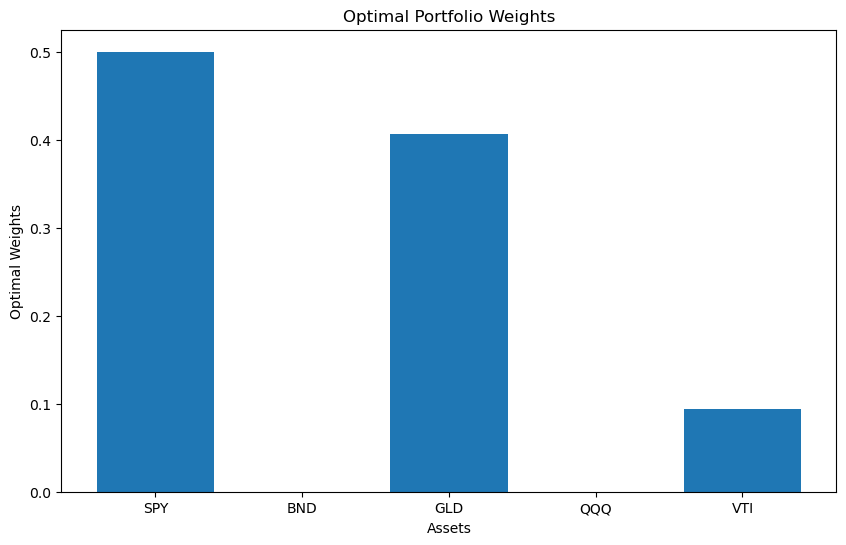

In [25]:
#Display the final portfolio in a plot
import matplotlib.pyplot as plt

#Import the required library
import matplotlib.pyplot as plt

#Create a bar chart of the optimal weights
plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)

#Add labels and a title
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

#Display the Chart
plt.show()